## Integrating a simple harmonic oscillator and trying to infer the spring constant

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.optimize as so
%matplotlib inline
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad  

In [2]:
def leapfrog(x0, v0, t_obs, phi_grad, dt, *args, **kwargs):
    #function that takes initial conditions that takes us to the next position 
    v0_5 = v0 + phi_grad(x0, *args, **kwargs)*dt/2.
    x = [] 
    v = [] 
    t = [] 

    tprime = 0.0
    xprime = x0
    vprime = v0
    
    for to in t_obs:
        while tprime + dt < to:
            xprime = xprime + dt*v0_5
            a      = -phi_grad(xprime, *args, **kwargs)
            vprime = (v0_5 + a*dt/2)
            v0_5   = v0_5 + a*dt
            tprime = tprime + dt        
        dt_tiny = to - tprime
        xprime = xprime + dt_tiny*v0_5
        a      = -phi_grad(xprime, *args, **kwargs)
        vprime = (v0_5 + a*dt_tiny/2)
        v0_5   = v0_5 + a*dt_tiny
        tprime = tprime + dt_tiny
        
        x.append(xprime)
        v.append(vprime)
        t.append(tprime)

    return np.array(x), np.array(v) #, np.array(t)

In [3]:
def phi_grad(x, k=1):
    return k*x

In [4]:
def genData(x, v, npoints, std_noise_x, std_noise_v):
    noise_x = np.random.normal(0, std_noise_x, len(x))
    noise_v = np.random.normal(0, std_noise_v, len(x))
    return noise_x + x, noise_v + v

In [5]:
def ln_likelihood(theta, data, dt_model):
    chi2 = 0
    k, x0, v0, *t_obs = theta
    x_obs, v_obs, sigma_x, sigma_v = data
    x, v = leapfrog(x0, v0, np.array(t_obs), phi_grad, dt, k=k)
    chi2 += -(v - v_obs)**2 / sigma_v**2 - 2*np.log(sigma_v)
    chi2 += -(x - x_obs)**2 / sigma_x**2 - 2*np.log(sigma_x)
    return 0.5*chi2.sum()

In [6]:
np.random.seed(42)

In [7]:
x0_true   = 100.
v0_true   = 100.
k_true    = 10.

dt        = 0.01
max_time  = 5.

nobspoints = 10
std_noise_x = 10.0
std_noise_v = 10.0

plot_xerr = np.zeros(nobspoints) + std_noise_x
plot_yerr = np.zeros(nobspoints) + std_noise_v
t_obs_true = np.random.uniform(0, max_time, nobspoints)
t_obs_true.sort()

#assert nmodelpoints > nobspoints, 'The number of model points must be greater than the number of observed points'

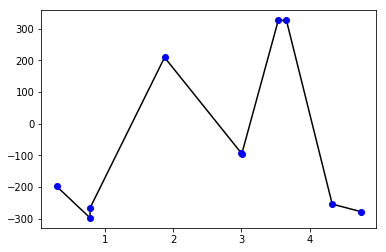

In [8]:
#generate true values and noisify them
x_true, v_true = leapfrog(x0_true, v0_true, t_obs_true, phi_grad, dt, k=k_true)
x_obs, v_obs = genData(x_true, v_true, nobspoints, std_noise_x, std_noise_v)
plt.plot(t_obs_true, v_obs, 'k')
#plt.plot(t_obs_true, x_obs, 'k')
#v_obs += 1000
plt.plot(t_obs_true, v_obs, 'bo')
#plt.plot(t_obs_true, x_obs, 'bo')

In [9]:
#assert np.allclose(t_true, t_obs), 'Observed times and integrated times are not the same'

In [10]:
data   = [x_obs, v_obs, std_noise_x, std_noise_v]
p_true = [k_true, x0_true, v0_true, t_obs_true]
k_guess = k_true  + np.random.normal(0, k_true)
x0_guess = x0_true + np.random.normal(0, std_noise_x)
v0_guess = v0_true + np.random.normal(0, std_noise_v)
t0_guess = t_obs_true + np.random.normal(0, 1., len(t_obs_true))
p0     = [k_guess, 
          x0_guess, 
          v0_guess] + (t0_guess).tolist()
args   = (data, dt)

#for plotting purposes
t_compare = np.linspace(0, max_time, 1000)

In [11]:
p0

[3.9936131008119506,
 97.08306250206724,
 93.98293387770603,
 2.142696245349935,
 0.7664753769430793,
 -0.27761772674371776,
 2.6952455063400014,
 1.7724487710141608,
 3.214438653720799,
 1.5806927651004516,
 2.331783660158595,
 4.527741964743799,
 5.492038112044991]

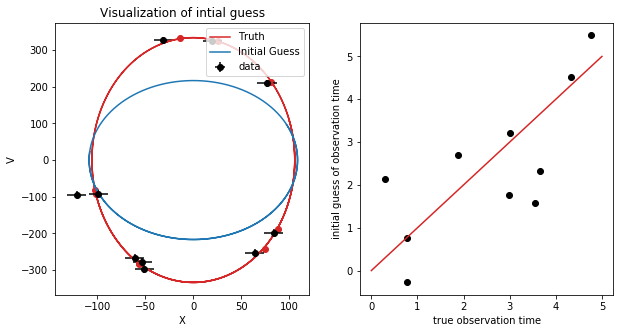

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#plot best fit from optimization 

#plot true values
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)
ax[0].plot(x_compare, v_compare, c='C3', label='Truth')
ax[0].scatter(x_true, v_true, c='C3')

x_compare, v_compare = leapfrog(x0_guess, v0_guess, t_compare, phi_grad, dt, k=k_guess)
ax[0].plot(x_compare, v_compare, c='C0', label = 'Initial Guess')
ax[0].errorbar(x_obs, v_obs, xerr = plot_xerr, yerr = plot_yerr, fmt='o', color='k', label='data')


ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('X')
ax[0].set_ylabel('V')
ax[0].set_title('Visualization of intial guess')

ax[1].plot(t_obs_true, t0_guess, 'ko')
ax[1].set_xlabel('true observation time')
ax[1].set_ylabel('initial guess of observation time')
ax[1].plot([0,max_time], [0, max_time], 'C3')

plt.savefig('initalGuess.jpg', rasterized=True)

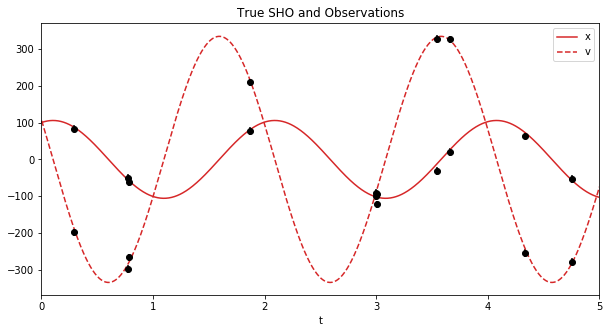

In [13]:
plt.figure(figsize=(10, 5))
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)

plt.plot(t_compare, x_compare, 'C3', label='x')
plt.plot(t_compare, v_compare, 'C3--', label='v')
plt.errorbar(t_obs_true, x_obs, yerr=std_noise_x, fmt='o', color='k')
plt.errorbar(t_obs_true, v_obs, yerr=std_noise_v, fmt='o', color='k')
plt.xlabel('t')
plt.legend()
plt.title('True SHO and Observations')
plt.xlim(0, max_time)
plt.savefig('dataGeneration.jpg', rasterized=True)

In [14]:
ln_likelihood(p0, data, dt)

-58630774.158825755

In [15]:
#%%timeit
#res = so.minimize(lambda *args : -ln_likelihood(*args),
#                  x0=p0, method='Powell', args=args) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [16]:
def nll(*args):
    return -ln_likelihood(*args)

In [17]:
res = so.minimize(nll,
                  x0=p0, method='Powell', args=args) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [18]:
print('The optimizer was successful: {0}'.format(res.success))
print('The {0} with {1} functional evaluations'.format(res.message, res.nfev))
print('The results are: {0}'.format(res.x))

The optimizer was successful: True
The Optimization terminated successfully. with 4382 functional evaluations
The results are: [  5.23626151 -22.39611678  93.26900788   2.14536008   0.69319373
  -0.12438114   2.55561886   1.79147693   3.51147693   2.14970455
   1.88755918   5.84738378   6.37738378]


In [19]:
print('The true values are: k = {0:0.2f}, x0 = {1:0.2f}, v0 = {2:0.2f}'.format(k_true, x0_true, v0_true))
print('The optimized values are: k = {0:0.2f}, x0 = {1:0.2f}, v0 = {2:0.2f}'.format(res.x[0], res.x[1], res.x[2], res.x[3]))


The true values are: k = 10.00, x0 = 100.00, v0 = 100.00
The optimized values are: k = 5.24, x0 = -22.40, v0 = 93.27


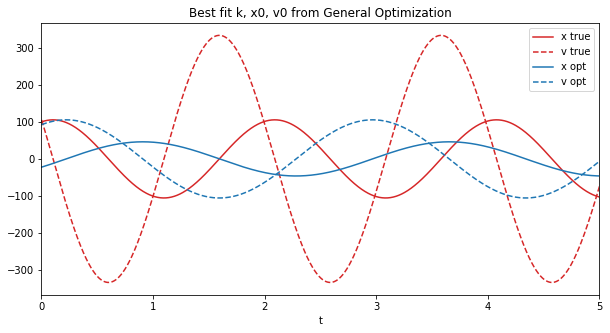

In [20]:
plt.figure(figsize=(10, 5))
#plot best fit from optimization 
#plot true values
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)
plt.plot(t_compare, x_compare, c='C3', label='x true')
plt.plot(t_compare, v_compare, 'C3--', label='v true')
#plt.scatter(t_obs_true, x_true, c='C3', edgecolor='k') 
#plt.scatter(t_obs_true, v_true, c='C3', edgecolor='k')

x_compare, v_compare = leapfrog(res.x[1], res.x[2], t_compare, phi_grad, dt, k=res.x[0])
plt.plot(t_compare, x_compare, c='C0', label='x opt')
plt.plot(t_compare, v_compare, 'C0--', label='v opt')
#plt.errorbar(res.x[3:], x_obs, yerr=std_noise_x, fmt='o', color='C0')
#plt.errorbar(res.x[3:], v_obs, yerr=std_noise_v, fmt='o', color='C0')
plt.legend()
plt.xlabel('t')
plt.xlim(0, max_time)

plt.title('Best fit k, x0, v0 from General Optimization')
plt.savefig('generalOptimizer_t.jpg', rasterized=True)

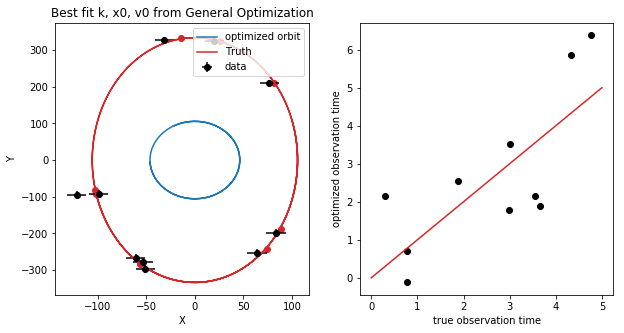

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#plot best fit from optimization 
x_compare, v_compare = leapfrog(res.x[1], res.x[2], t_compare, phi_grad, dt, k=res.x[0])
ax[0].plot(x_compare, v_compare, c='C0', label = 'optimized orbit')
ax[0].errorbar(x_obs, v_obs, xerr = plot_xerr, yerr = plot_yerr, fmt='o', color='k', label='data')

#plot true values
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)
ax[0].plot(x_compare, v_compare, c='C3', label='Truth')
ax[0].scatter(x_true, v_true, c='C3')
ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('Best fit k, x0, v0 from General Optimization')

ax[1].plot(t_obs_true, res.x[3:], 'ko')
ax[1].set_xlabel('true observation time')
ax[1].set_ylabel('optimized observation time')
ax[1].plot([0,max_time], [0, max_time], 'C3')
fig.savefig('generalOptimizer_xv.jpg', rasterized=True)

In [22]:
grad_ln_like = grad(nll)

In [23]:
grads = []

k = k_true
x0 = x0_true
v0 = v0_true
t0 = t_obs_true
epsilon = 0.0001
k = k_true + epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
kp = nll(p0_test, data, dt)
k = k_true - epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
km = nll(p0_test, data, dt)
k = k_true

grads.append((kp - km)/epsilon)


x0 = x0_true + epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
xp = nll(p0_test, data, dt)
x0 = x0_true - epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
xm = nll(p0_test, data, dt)
x0 = x0_true

grads.append((xp - xm)/epsilon)

v0 = v0_true + epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
vp = nll(p0_test, data, dt)
v0 = v0_true - epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
vm = nll(p0_test, data, dt)
v0 = v0_true

grads.append((vp - vm)/epsilon)

for i, t in enumerate(t0):
    t_obs_true[i] = t + epsilon/2.
    p0_test = [k, x0, v0] + (t0).tolist()
    tp = nll(p0_test, data, dt)
    t_obs_true[i] = t - epsilon/2.
    p0_test = [k, x0, v0] + (t0).tolist()
    tm = nll(p0_test, data, dt)
    t_obs_true[i] = t
    
    grads.append((tp - tm)/epsilon)
    
    


In [24]:
grads

[4.334719902061579,
 -0.23724854642637183,
 -0.016978355290575564,
 -9.145172890541176,
 14.4919564215229,
 -64.38345218747088,
 -3.4721863237763273,
 71.82544872080143,
 61.372280436344795,
 62.30750314422551,
 -21.6577882945046,
 -77.99243139970713,
 -1.8485152821057227]

In [25]:
grad_ln_like(p0_test, data, dt)

[array(4.30802322),
 array(-0.23706279),
 array(-0.01684116),
 array(-9.14512867),
 array(14.48741374),
 array(-64.38192622),
 array(-3.47119079),
 array(71.82538822),
 array(61.37194839),
 array(62.30968664),
 array(-21.65839795),
 array(-78.03695444),
 array(-1.92372166)]

In [26]:
#%%timeit
#args = (data, dt_model) 
#res = so.minimize(nll, x0=p0, args=args, jac=grad_ln_like) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [ ]:
p0

[3.9936131008119506,
 97.08306250206724,
 93.98293387770603,
 2.142696245349935,
 0.7664753769430793,
 -0.27761772674371776,
 2.6952455063400014,
 1.7724487710141608,
 3.214438653720799,
 1.5806927651004516,
 2.331783660158595,
 4.527741964743799,
 5.492038112044991]

In [ ]:
args = (data, dt) 
res = so.minimize(nll, x0=p0, args=args, jac=grad_ln_like) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [ ]:
print('The optimizer was successful: {0}'.format(res.success))
print('The {0} with {1} functional evaluations'.format(res.message, res.nfev))
print('The results are: {0}'.format(res.x))

In [ ]:
print('The true values are: k = {0:0.2f}, x0 = {1:0.2f}, v0 = {2:0.2f}'.format(k_true, x0_true, v0_true))
print('The optimized values are: k = {0:0.5f}, x0 = {1:0.5f}, v0 = {2:0.5f}'.format(res.x[0], res.x[1], res.x[2], res.x[3]))


In [ ]:
plt.figure(figsize=(10, 5))


#plot best fit from optimization 
x_compare, v_compare = leapfrog(res.x[1], res.x[2], t_compare, phi_grad, dt, k=res.x[0])
plt.plot(t_compare, x_compare, c='C0', label='x opt')
plt.plot(t_compare, v_compare, 'C0--', label='v opt')
#plt.errorbar(res.x[3:], x_obs, c='C0', yerr=std_noise_x, fmt='o')
#plt.errorbar(res.x[3:], v_obs, c='C0', yerr=std_noise_v, fmt='o')

#plot true values
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)
plt.plot(t_compare, x_compare, c='C3', label='x true')
plt.plot(t_compare, v_compare, 'C3--', label='v true')
#plt.scatter(t_obs_true, x_true, c='C3') 
#plt.scatter(t_obs_true, v_true, c='C3')

plt.legend()
plt.xlabel('t')

plt.xlim(0, max_time)
plt.title('Best fit k, x0, v0 from Optimization')
plt.savefig('gradientOptimizer_t.jpg', rasterized=True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#plot best fit from optimization 

#plot true values
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)
ax[0].plot(x_compare, v_compare, c='C3', label='Truth')
ax[0].scatter(x_true, v_true, c='C3')

x_compare, v_compare = leapfrog(res.x[1], res.x[2], t_compare, phi_grad, dt, k=res.x[0])
ax[0].plot(x_compare, v_compare, c='C0', label = 'optimized orbit')
ax[0].errorbar(x_obs, v_obs, xerr = plot_xerr, yerr = plot_yerr, fmt='o', color='k', label='data')


ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('X')
ax[0].set_ylabel('V')
ax[0].set_title('Best fit k, x0, v0 from Gradient Optimization')

ax[1].plot(t_obs_true, res.x[3:], 'ko')
ax[1].set_xlabel('true observation time')
ax[1].set_ylabel('optimized observation time')
ax[1].plot([0,max_time], [0, max_time], 'C3')

fig.savefig('gradientOptimizer.jpg', rasterized=True)